# Imports

In [2]:
import os
import re

from sklearn import preprocessing
from pprint import pprint
import numpy as np
import pandas as pd
import torch

In [3]:
data_path = './data/'
os.path.exists(data_path)

True

In [4]:
# Get only the data folders
data_batches = pd.Series(os.listdir(data_path))
data_batches = data_batches.apply(lambda x: os.path.join(data_path, x))
data_batches = data_batches[ data_batches.apply(os.path.isdir) ]
print(data_batches)

0    ./data/data_5
1    ./data/data_6
2    ./data/data_1
4    ./data/data_4
5    ./data/data_0
7    ./data/data_2
8    ./data/data_7
9    ./data/data_3
dtype: object


In [5]:
# Examine file contents
batch = data_batches[0]
parents = [os.path.join(batch, parent) for parent in os.listdir(batch)]

parent = parents[0]
fragments = [os.path.join(parent, fragment) for fragment in os.listdir(parent)]

fragment = fragments[0]
pd.read_csv(fragment)

,x,y,r,err,spacing
0,-0.000901,0.001392,9.094312e-03,1.338222e-04,16000.0
1,-0.000014,0.002460,9.296191e-01,3.060643e-05,20000.0
2,NaN,NaN,6.965975e+06,4.829333e+03,NaN
3,318.975133,-206.624164,2.087026e+03,3.072780e+01,16000.0
4,502.092555,16.802996,2.057903e+05,1.091599e+01,20000.0
5,NaN,NaN,5.269384e+10,1.826567e+07,NaN
6,0.007075,-0.011160,4.593338e+01,5.689770e-03,20000.0
7,-0.026541,-0.016466,2.304290e+01,1.576539e-02,20000.0
8,-0.000101,0.000090,8.391452e-03,2.456272e-04,16000.0


Read in proper element `r` values, and filename from each file.
Regex out the fragment number and parent.

In [6]:
headers = ['hke', 'pqi', 'sma', 'pn1', 'pn2', 'pn3', 'q03', 'q12', 'qec']

In [7]:
# Open all batches, open all parents in each batch, read all fragments from each parent
proper_element_list = []
basename_list = []
for batch in data_batches:
    parents = [os.path.join(batch, parent) for parent in os.listdir(batch)]
    for parent in parents:
        fragments = [os.path.join(parent, fragment) for fragment in os.listdir(parent)]
        for fragment in fragments:
            basename = os.path.basename(fragment)
            df = pd.read_csv(fragment)
            proper_element_list.append(df['r'])
            basename_list.append(basename)

proper_element_array = np.array(proper_element_list)
basename_array = np.array(basename_list)

In [8]:
proper_element_df = pd.DataFrame(proper_element_array, columns=headers)
proper_element_df['basename'] = basename_array
proper_element_df['id'] = proper_element_df['basename'].str.findall(r'[0-9]+')
proper_element_df['parent'] = proper_element_df['id'].str[0]
proper_element_df.head()

,hke,pqi,sma,pn1,pn2,pn3,q03,q12,qec,basename,id,parent
0,0.009094,0.929619,6.965975e+06,2087.026190,205790.341851,5.269384e+10,45.933380,23.042898,0.008391,P_3262_F_395.prp,"[3262, 395]",3262
1,0.010053,0.926731,6.998754e+06,2310.516728,205435.828750,5.281767e+10,45.995874,22.987567,0.011284,P_1031_F_350.prp,"[1031, 350]",1031
2,0.007225,0.925009,6.979389e+06,1659.257148,204942.263607,5.274455e+10,45.950861,23.039709,0.008700,P_1031_F_411.prp,"[1031, 411]",1031
3,0.006841,0.928327,6.975948e+06,1570.986862,205598.973751,5.273154e+10,45.938516,23.010767,0.007418,P_1031_F_393.prp,"[1031, 393]",1031
4,0.003548,0.929030,6.933649e+06,813.488407,205432.774161,5.257143e+10,45.863019,22.975594,0.005378,P_1031_F_366.prp,"[1031, 366]",1031


In [9]:
proper_element_df

,hke,pqi,sma,pn1,pn2,pn3,q03,q12,qec,basename,id,parent
0,0.009094,0.929619,6.965975e+06,2087.026190,205790.341851,5.269384e+10,45.933380,23.042898,0.008391,P_3262_F_395.prp,"[3262, 395]",3262
1,0.010053,0.926731,6.998754e+06,2310.516728,205435.828750,5.281767e+10,45.995874,22.987567,0.011284,P_1031_F_350.prp,"[1031, 350]",1031
2,0.007225,0.925009,6.979389e+06,1659.257148,204942.263607,5.274455e+10,45.950861,23.039709,0.008700,P_1031_F_411.prp,"[1031, 411]",1031
3,0.006841,0.928327,6.975948e+06,1570.986862,205598.973751,5.273154e+10,45.938516,23.010767,0.007418,P_1031_F_393.prp,"[1031, 393]",1031
4,0.003548,0.929030,6.933649e+06,813.488407,205432.774161,5.257143e+10,45.863019,22.975594,0.005378,P_1031_F_366.prp,"[1031, 366]",1031
...,...,...,...,...,...,...,...,...,...,...,...,...
2955,0.003746,0.931643,6.941890e+06,859.205888,206029.325210,5.260266e+10,45.889498,23.097873,0.004343,P_3338_F_357.prp,"[3338, 357]",3338
2956,0.007023,0.928013,6.805537e+06,1602.716623,204247.712418,5.208333e+10,45.655064,22.922989,0.007529,P_3338_F_378.prp,"[3338, 378]",3338
2957,0.006637,0.930493,6.963805e+06,1523.463723,205954.188765,5.268563e+10,45.898418,23.143898,0.007644,P_3338_F_381.prp,"[3338, 381]",3338
2958,0.006974,0.928349,6.959336e+06,1600.664647,205481.060773,5.266872e+10,45.948925,23.004935,0.007791,P_3338_F_383.prp,"[3338, 383]",3338


In [10]:
# Vectorized triangular (non-redundant) pair-table generator

n = proper_element_df.shape[0]
parent_array = proper_element_df['parent'].to_numpy()

# Create indices for all pairs (i, j) where i > j
i_indices, j_indices = np.tril_indices(n, k=-1)

# Get data for all i and j indices at once
data_i = proper_element_array[i_indices]  # Shape: (num_pairs, 9)
data_j = proper_element_array[j_indices]  # Shape: (num_pairs, 9)
is_same_parent = (parent_array[i_indices] == parent_array[j_indices]).astype(int)

# Concatenate all data horizontally
pair_array = np.column_stack([data_i, data_j, is_same_parent])

In [11]:
pair_array.shape

(4379320, 19)

In [12]:
pair_df = pd.DataFrame(pair_array)
pair_df.dropna(inplace=True)

In [13]:
n_true = pair_df[pair_df[18] == True].shape[0]
n_false = pair_df[pair_df[18] == False].shape[0]

In [ ]:
n_true

89745

In [ ]:
n_false

4108008

In [ ]:
# Separate data into binary classes
is_positive = (pair_df[18] == 1)
pos_pair_df = pair_df[is_positive]
neg_pair_df = pair_df[~is_positive]

pos_pair_array = pos_pair_df.to_numpy()
neg_pair_array = neg_pair_df.to_numpy()

In [ ]:
# Shuffle data

np.random.default_rng(836745).shuffle(pos_pair_array)
np.random.default_rng(487563).shuffle(neg_pair_array)

In [ ]:
# sample data sets to have rough balance
reduced_neg_pair_array = neg_pair_array[::45]

In [ ]:
dataset = np.concatenate((reduced_neg_pair_array, pos_pair_array))

In [ ]:
from dataset import PairDataset

ds = PairDataset(dataset)

In [ ]:
ds.choose_set('train', 'mee')

In [ ]:
ds.subset.shape

torch.Size([126724, 6])

In [ ]:
# test dataset heterogeneity
torch.sum(ds.sublab) / ds.sublab.shape[0]

tensor(0.4970)

In [ ]:
# Check dataset size and GPU memory
print(f"Dataset shape: {ds.subset.shape}")
dataset_size_mb = ds.subset.nbytes / (1024**2)
print(f"Dataset size: {dataset_size_mb:.2f} MB")

# Check GPU memory
if torch.cuda.is_available():
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    gpu_memory_free = torch.cuda.memory_reserved(0) / (1024**3) 
    print(f"GPU total memory: {gpu_memory_gb:.2f} GB")
    print(f"GPU memory currently used: {gpu_memory_free:.2f} GB")
    
    # Rule of thumb: dataset should be < 10% of available GPU memory
    recommended_max_mb = (gpu_memory_gb * 1024) * 0.1
    print(f"Recommended max dataset size for GPU: {recommended_max_mb:.0f} MB")
    
    if dataset_size_mb < recommended_max_mb:
        print("✅ Dataset is small enough to move to GPU")
    else:
        print("⚠️  Dataset might be too large - stick with batch-by-batch transfer")

Dataset shape: torch.Size([126724, 6])
Dataset size: 2.90 MB
GPU total memory: 11.60 GB
GPU memory currently used: 0.00 GB
Recommended max dataset size for GPU: 1188 MB
✅ Dataset is small enough to move to GPU


In [ ]:
# Option 1: Move entire dataset to GPU (use if dataset is small enough)
# Uncomment these lines if your dataset fits comfortably in GPU memory:
ds.subset = ds.subset.cuda()
ds.sublab = ds.sublab.cuda()
print("Dataset moved to GPU")

print(f"ds.subset device: {ds.subset.device}")
print(f"ds.sublab device: {ds.sublab.device}")

# Option 2: Keep dataset on CPU and move batches (current approach)
# print("Using batch-by-batch GPU transfer (safer for large datasets)")

Dataset moved to GPU
ds.subset device: cuda:0
ds.sublab device: cuda:0


In [ ]:
import logging
# Build sequential ANN model
model = torch.nn.Sequential(
    torch.nn.Linear(6, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 2),
    torch.nn.ReLU(),
    torch.nn.LogSoftmax()
)

device = torch.device("cuda")
model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
train_loader = torch.utils.data.DataLoader(dataset=ds, batch_size=1000, shuffle=True, drop_last=True, num_workers=0)

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        # Move tensors to GPU
        # inputs = inputs.cuda()
        # labels = labels.cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=2).float()
        loss = criterion(outputs, one_hot_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

/home/michael/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1751: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/500], Loss: 0.6910
Epoch [2/500], Loss: 0.6899
Epoch [3/500], Loss: 0.6888
Epoch [4/500], Loss: 0.6882
Epoch [5/500], Loss: 0.6878
Epoch [6/500], Loss: 0.6878
Epoch [7/500], Loss: 0.6876
Epoch [8/500], Loss: 0.6876
Epoch [9/500], Loss: 0.6875
Epoch [10/500], Loss: 0.6875
Epoch [11/500], Loss: 0.6874
Epoch [12/500], Loss: 0.6873
Epoch [13/500], Loss: 0.6874
Epoch [14/500], Loss: 0.6872
Epoch [15/500], Loss: 0.6871
Epoch [16/500], Loss: 0.6872
Epoch [17/500], Loss: 0.6871
Epoch [18/500], Loss: 0.6872
Epoch [19/500], Loss: 0.6870
Epoch [20/500], Loss: 0.6870
Epoch [21/500], Loss: 0.6871
Epoch [22/500], Loss: 0.6870
Epoch [23/500], Loss: 0.6869
Epoch [24/500], Loss: 0.6869
Epoch [25/500], Loss: 0.6870
Epoch [26/500], Loss: 0.6869
Epoch [27/500], Loss: 0.6868
Epoch [28/500], Loss: 0.6867
Epoch [29/500], Loss: 0.6867
Epoch [30/500], Loss: 0.6868
Epoch [31/500], Loss: 0.6866
Epoch [32/500], Loss: 0.6867
Epoch [33/500], Loss: 0.6867
Epoch [34/500], Loss: 0.6866
Epoch [35/500], Loss: 0

In [ ]:
import matplotlib.pyplot as plt

torch.max(test_subset[i]) = tensor(5.2750e+10)
torch.max(test_subset[i]) = tensor(5.2808e+10)
torch.max(test_subset[i]) = tensor(5.2573e+10)
torch.max(test_subset[i]) = tensor(5.2753e+10)
torch.max(test_subset[i]) = tensor(5.2738e+10)
torch.max(test_subset[i]) = tensor(5.2792e+10)


/home/michael/Documents/Projects/sda-model/dataset.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict[key] = torch.tensor(data_dict[key]).to(data_type)
/tmp/ipykernel_67146/959494952.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(test_subset, labels=[f"{i}" for i in range(6)])


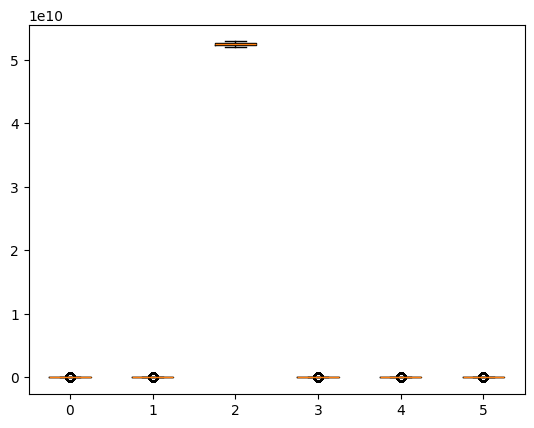

In [ ]:
ds.choose_set('test', 'qtn')
test_subset = ds.subset.cpu()

for i in range(6):
    print(f"{torch.max(test_subset[i]) = }")

plt.boxplot(test_subset, labels=[f"{i}" for i in range(6)])
plt.show()